# Pandas

[Pandas](http://pandas.pydata.org/) je biblioteka za analizu podataka. Ilustrirat ćemo njeno korištenje na jednostavnom primjeru analize podataka iz IMDB baze.

U ak. godini 2014./15. koristio sam biblioteku [pattern](http://www.clips.ua.ac.be/pages/pattern), koja služi za rudarenje podataka s Interneta. No kako pattern još nije prešao na Python 3, koristit ću [requests](https://github.com/kennethreitz/requests) (za učitavanje web stranica) i [pyquery](https://pythonhosted.org/pyquery/) (za analizu HTML-a). Kako pyquery nije instaliran na Sagemath-u instalirao sam ga lokalno tako što sam u terminalu napisao
```
anaconda3
pip install --user pyquery
```

In [4]:
import requests
from pyquery import PyQuery as pq

Dohvaćamo podatke s IMDB-a o filmovima sa zemljom porijekla Hrvatska, smimljenim između 1945. i 2016.

In [6]:
import time
url = 'http://www.imdb.com/search/title'
params = dict(sort='num_votes,desc', start=1, title_type='feature', year='1945,2016',countries='hr', languages='hr')
r=[]
for i in range(1,150,50): # takvih filmova ima manje od 150
    params['start']=i
    r.append(requests.get(url, params=params))
    time.sleep(5)

Parsiranje podataka koje spremamo u datoteku `filmovi.txt`.

In [53]:
with open('filmovi2.txt','w') as f:
    for i in range(len(r)):
        dom = pq(r[i].text)
        for film in dom.find('td.title'):
            film = pq(film)
            title = film.find('a').eq(0).text()
            year = film.find('span.year_type').text()
            rating = film.find('span.value').text()
            runtime = film.find('span.runtime').text()
            director = film.find('span.credit').find('a').eq(0).text()
            genres = film.find('span.genre').find('a').text()
            f.write('\t'.join((title, year, runtime, rating,director, genres))+'\n')

In [54]:
!head filmovi2.txt

The Priest's Children	(2013)	96 mins.	6.8	Vinko Bresan	Comedy Drama
Metastases	(2009)	82 mins.	7.7	Branko Schmidt	Crime Drama
Fine Dead Girls	(2002)	77 mins.	7.2	Dalibor Matanic	Drama Thriller
Vegetarian Cannibal	(2012)	85 mins.	7.2	Branko Schmidt	Drama
Sonja and the Bull	(2012)	103 mins.	7.2	Vlatka Vorkapic	Comedy Romance
What Is a Man Without a Moustache?	(2005)	109 mins.	7.1	Hrvoje Hribar	Comedy Drama Romance
The High Sun	(2015)	123 mins.	7.2	Dalibor Matanic	Drama Romance
Play Me a Love Song	(2007)	106 mins.	7.7	Goran Kulenovic	Comedy
A Wonderful Night in Split	(2004)	100 mins.	7.2	Arsen A. Ostojic	Drama Music
Number 55	(2014)	90 mins.	7.2	Kristijan Milic	War


### Analiza podataka pomoću biblioteke Pandas

In [85]:
import pandas as pd
names = ['title', 'year','runtime', 'rating', 'director', 'genres']
data = pd.read_csv('filmovi2.txt', delimiter='\t', names=names)
print ("Number of rows: {:d}".format(data.shape[0]))
data.head()

Number of rows: 137


,title,year,runtime,rating,director,genres
0,The Priest's Children,(2013),96 mins.,6.8,Vinko Bresan,Comedy Drama
1,Metastases,(2009),82 mins.,7.7,Branko Schmidt,Crime Drama
2,Fine Dead Girls,(2002),77 mins.,7.2,Dalibor Matanic,Drama Thriller
3,Vegetarian Cannibal,(2012),85 mins.,7.2,Branko Schmidt,Drama
4,Sonja and the Bull,(2012),103 mins.,7.2,Vlatka Vorkapic,Comedy Romance


In [91]:
data.ix[118]

title        Marija's Own
year               (2011)
runtime               NaN
rating                8.9
director    Zeljka Sukova
genres             Comedy
Name: 118, dtype: object

In [93]:
data['runtime'].fillna('0 mins.', inplace=True);
clean_runtime = [int(v.split(' ')[0]) for v in data.runtime]
data['runtime'] = clean_runtime
data['year'] = [int(y[1:-1]) for y in data.year]
data.rating[data.rating=='-'] = '0';
clean_rating = [float(v) for v in data.rating]
data['rating'] = clean_rating
clean_genres = [g.replace(' ','|') for g in data.genres]
data['genres'] = clean_genres
data.head()

/projects/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,title,year,runtime,rating,director,genres
0,The Priest's Children,2013,96,6.8,Vinko Bresan,Comedy|Drama
1,Metastases,2009,82,7.7,Branko Schmidt,Crime|Drama
2,Fine Dead Girls,2002,77,7.2,Dalibor Matanic,Drama|Thriller
3,Vegetarian Cannibal,2012,85,7.2,Branko Schmidt,Drama
4,Sonja and the Bull,2012,103,7.2,Vlatka Vorkapic,Comedy|Romance


In [94]:
data.ix[118]

title        Marija's Own
year                 2011
runtime                 0
rating                8.9
director    Zeljka Sukova
genres             Comedy
Name: 118, dtype: object

In [106]:
# ne želim više da mi javlja ova upozorenja
pd.options.mode.chained_assignment = None # default='warn'

In [95]:
data[['year','runtime', 'rating']].describe()

,year,runtime,rating
count,137.000000,137.000000,135.000000
mean,2009.255474,85.430657,6.895556
std,6.067063,29.791628,1.612769
min,1980.000000,0.000000,0.000000
25%,2008.000000,77.000000,6.750000
50%,2011.000000,90.000000,7.200000
75%,2013.000000,100.000000,7.700000
max,2016.000000,200.000000,9.500000


In [107]:
import numpy as np
data.runtime[data.runtime==0] = np.nan;
data.runtime[data.rating==0] = np.nan;

In [108]:
data[['runtime', 'rating']].describe()

,runtime,rating
count,123.000000,130.000000
mean,91.495935,7.160769
std,19.450810,0.887685
min,46.000000,3.800000
25%,80.000000,6.800000
50%,90.000000,7.200000
75%,100.500000,7.700000
max,200.000000,9.500000


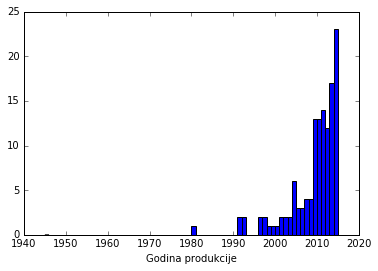

In [109]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(data.year, bins=np.arange(1945, 2016))
plt.xlabel("Godina produkcije");

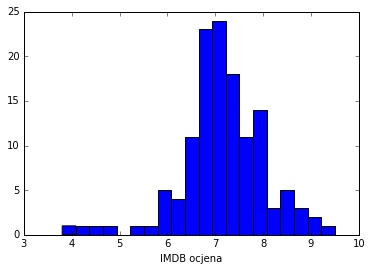

In [116]:
plt.hist(data.rating.dropna(), bins=20)
plt.xlabel("IMDB ocjena");

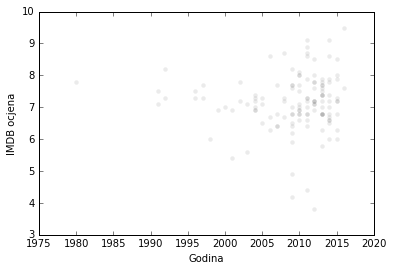

In [117]:
plt.scatter(data.year, data.rating, lw=0, alpha=.08, color='k')
plt.xlabel("Godina")
plt.ylabel("IMDB ocjena");

In [118]:
data.rating[data.rating==0] = np.nan;
data[data.rating == data.rating.min()][['title', 'year', 'rating','director', 'genres']]

,title,year,rating,director,genres
54,Larin izbor: Izgubljeni princ,2012,3.8,Tomislav Rukavina,Drama


In [119]:
data[data.rating == data.rating.max()][['title', 'year', 'rating','director',  'genres']]

,title,year,rating,director,genres
128,Goran,2016,9.5,Nevio Marasovic,Drama|Thriller


In [120]:
genres = set()
for m in data.genres:
    genres.update(g for g in m.split('|'))
genres = sorted(genres)

for genre in genres:
    data[genre] = [genre in movie.split('|') for movie in data.genres]
         
data.head()

,title,year,runtime,rating,director,genres,Action,Adventure,Animation,Biography,...,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,The Priest's Children,2013,96.0,6.8,Vinko Bresan,Comedy|Drama,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Metastases,2009,82.0,7.7,Branko Schmidt,Crime|Drama,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Fine Dead Girls,2002,77.0,7.2,Dalibor Matanic,Drama|Thriller,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,Vegetarian Cannibal,2012,85.0,7.2,Branko Schmidt,Drama,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Sonja and the Bull,2012,103.0,7.2,Vlatka Vorkapic,Comedy|Romance,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [121]:
genre_count = data[genres].sum()
pd.DataFrame({'Genre Count': genre_count})

,Genre Count
Action,11
Adventure,6
Animation,3
Biography,4
Comedy,39
Crime,10
Drama,93
Family,10
Fantasy,5
History,3


In [122]:
petoljetka =  (data.year // 5) * 5

#tyd = data[['title', 'year']] na ovo se buni, 
#pa koristim .loc (http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy)
tyd = data.loc[:, ('title', 'year')]
tyd['petoljetka'] = petoljetka;

tyd.head()

,title,year,petoljetka
0,The Priest's Children,2013,2010
1,Metastases,2009,2005
2,Fine Dead Girls,2002,2000
3,Vegetarian Cannibal,2012,2010
4,Sonja and the Bull,2012,2010


year
1980    7.800000
1990    7.525000
1995    7.116667
2000    6.900000
2005    6.874074
2010    7.245588
2015    7.481818
Name: Petoljetka mean, dtype: float64


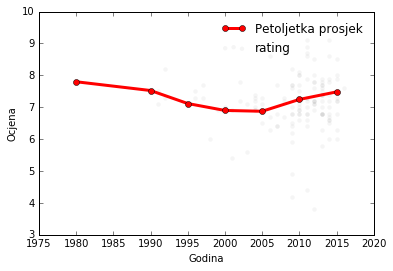

In [123]:
pet_mean = data.groupby(petoljetka).rating.mean()
pet_mean.name = 'Petoljetka mean'
print (pet_mean)

plt.plot(pet_mean.index, pet_mean.values, 'o-',
        color='r', lw=3, label='Petoljetka prosjek')
plt.scatter(data.year, data.rating, alpha=.04, lw=0, color='k')
plt.xlabel("Godina")
plt.ylabel("Ocjena")
plt.legend(frameon=False);

In [124]:
for year, subset in data.groupby('year'):
    print (year, subset[subset.rating == subset.rating.max()].title.values)

1980 ['Izgubljeni zavicaj']
1991 ['The Time of Warriors']
1992 ['Kamenita vrata']
1996 ['Putovanje tamnom polutkom']
1997 ['Treca zena']
1998 ['Transatlantik']
1999 ['Red Dust']
2000 ['Celestial Body']
2001 ['The Miroslav Holdinc Co.']
2002 ['24 Hours']
2003 ['Bore Lee: U kandzama velegrada']
2004 ['The Society of Jesus']
2005 ['Snivaj, zlato moje']
2006 ['Crveno i crno']
2007 ['Play Me a Love Song']
2008 ['Blazeni Augustin Kazotic']
2009 ['Da mogu...']
2010 ['Prokletstvo Krumpira']
2011 ['Bella Biondina']
2012 ["Once Upon a Winter's Night"]
2013 ['Glazbena kutija']
2014 ['Vlog']
2015 ['Memoirs of a Broken Mind']
2016 ['Goran']


In [125]:
from verzije import *
from IPython.display import HTML
HTML(print_sysinfo()+info_packages('pandas, numpy,requests, pyquery'))

Python verzija,3.5.1
kompajler,GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
sustav,Linux
broj CPU-a,8
interpreter,64bit
pandas verzija,0.18.0
numpy verzija,1.10.4
requests verzija,2.9.1
pyquery verzija,1.2.11
